# Behavioral Profile Stratification via Unsupervised learning

### TODO

> Please report some description here about the pipeline and what I am going to find in the notebook

## Step 1: Data Loading

> Short description here - and notes on Data Accessibility

In [1]:
from dataset import access_db, data_wrangling, cohort_info

In [2]:
# it returns a dictionary of pandas dataframes storing tables from the db
tables = access_db()

In [3]:
# reduced dictionary (it excludes tables and subjects taht are not required, e.g., ados-2modulo4, eas)
rid_tables = data_wrangling(tables)

In [4]:
# it returns dictionary of subjects info and encounters
pinfo, penc = cohort_info(rid_tables)

## Step 2: Feature Processing

> Short description here

In [5]:
from features import DataFeatures

In [6]:
datafeatures = DataFeatures(level=4, df_dict=rid_tables)

In [7]:
behr, (bt_to_idx, idx_to_bt) = datafeatures.create_level_tokens()

In [8]:
feat_df, feat_df_scaled = datafeatures.create_level_features()

---

## Step 3: Embeddings

> Short description here

In [9]:
from pt_embedding import Pembeddings

In [10]:
model = Pembeddings(behr, bt_to_idx)

In [11]:
svd_pid_list, svd_mtx = model.tfidf()

Performing SVD on the TF-IDF matrix...


In [12]:
# glove_pid_list, glove_emb = model.glove_pemb()

---

## Step 4: Clustering

> Short description here

In [13]:
from clustering import HclustEmbeddings, HclustFeatures
import utils as ut

In [14]:
hclust_emb = HclustEmbeddings(min_cl=ut.min_cl, max_cl=ut.max_cl, 
                              affinity='euclidean', linkage='ward')

### `TF-IDF` Embedding

In [15]:
# TFIDF EMBEDDING
tfidf_best_cl = hclust_emb.find_best_nclu(svd_mtx, n_iter=ut.n_iter, 
                                          subsampl=ut.subsampl)

(*) Iter 0 -- N clusters 4
Counts of N clusters:
N clusters -- Count
4 1

Best N cluster:4


In [16]:
tfidf_subc = hclust_emb.fit(svd_mtx, svd_pid_list, tfidf_best_cl)

(*) Number of clusters 4 -- Silhouette score 0.43
Cluster 0 -- Numerosity 40
Cluster 1 -- Numerosity 108
Cluster 2 -- Numerosity 27
Cluster 3 -- Numerosity 30






### `Glove` Embedding

In [17]:
# GLOVE EMBEDDING
# glv_best_cl = hclust_emb.find_best_nclu(glove_emb, n_iter=ut.n_iter, subsampl=ut.subsampl)

In [18]:
# glv_subc = hclust_emb.fit(glove_emb, glove_pid_list, glv_best_cl)

### Clustering and Feature Representation

> Short description here

In [19]:
hclust_feat = HclustFeatures(min_cl=ut.min_cl, max_cl=ut.max_cl, 
                             affinity='euclidean', linkage='ward')

In [20]:
# FEATURES REPRESENTATION
feat_best_cl = hclust_feat.find_best_nclu(feat_df_scaled, n_iter=ut.n_iter, subsampl=ut.subsampl)

(*) Iter 0 -- N clusters 6
Counts of N clusters:
N clusters -- Count
6 1

Best N cluster:6


In [21]:
feat_subc = hclust_feat.fit(feat_df_scaled, feat_best_cl)

(*) Number of clusters 6 -- Silhouette score 0.24
Cluster 0 -- Numerosity 187
Cluster 1 -- Numerosity 2
Cluster 2 -- Numerosity 5
Cluster 3 -- Numerosity 1
Cluster 4 -- Numerosity 2
Cluster 5 -- Numerosity 8






## Step 5: Clustering II (Visualization) 

> Short description here

In [22]:
from visualization import Visualization

In [23]:
viz = Visualization(pinfo, ut.col_dict, ut.c_out)

In [24]:
# Example of visulaization for tfidf embeddings
# Prepare data for umap and dendrogram
umap_mtx, pid_subc_list = viz.data_scatter_dendrogram(svd_mtx, tfidf_subc, svd_pid_list, random_state=42,
                                                      n_neighbors = 100,
                                                      min_dist=0.0)

Loading BokehJS ...

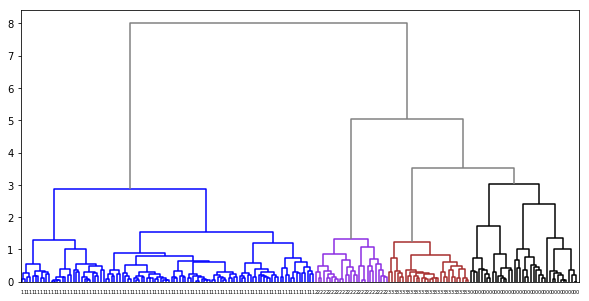

In [25]:
viz.scatterplot_dendrogram(svd_mtx, umap_mtx, pid_subc_list, 10, 5)

In [26]:
# Prepare data for heatmap
emb_scaled = viz.data_heatmap_emb(behr, bt_to_idx, tfidf_subc)

In [27]:
viz.heatmap_emb(emb_scaled, 500, 800)